In [1]:
import sys
sys.path.append('../')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
WYSCOUT_ID = 5414111
SKILLCORNER_ID = 952209

NETWORKS_PATH = f'../../data/networks/match_{SKILLCORNER_ID}/'
PASSES_DF_PATH = NETWORKS_PATH + 'passes_df.csv'

DATA_PATH= f'../../data/'
XT_PLOT_PATH = DATA_PATH + 'smoothed_xt.csv'
METADATA_PATH = DATA_PATH + f'skillcorner/{SKILLCORNER_ID}_metadata.csv'

In [3]:
passes_df = pd.read_csv(PASSES_DF_PATH)
xt_table = pd.read_csv(XT_PLOT_PATH)

# Utils

## ΔxT

In [4]:
pitch_length, pitch_width = pd.read_csv(METADATA_PATH)[['pitch_length', 'pitch_width']].values[0]
cell_width = pitch_length / xt_table.shape[1]
cell_height = pitch_width / xt_table.shape[0]

def adjust_coordinates(x, y, direction):
    if direction == 'TOP_TO_BOTTOM':
        x = - x + pitch_length/2
        y = -y + pitch_width/2
    elif direction == 'BOTTOM_TO_TOP':
        x = x + pitch_length/2
        y = y + pitch_width/2
    return x, y

def get_xt_index(x, y, direction):
    x_adj, y_adj = adjust_coordinates(x, y, direction)
    x_index = int(min(x_adj // cell_width, xt_table.shape[1] - 1))
    y_index = int(min(y_adj // cell_height, xt_table.shape[0] - 1))
    return x_index, y_index

def get_xt_value(x, y, direction):
    x_index, y_index = get_xt_index(x, y, direction)
    return xt_table.iat[y_index, x_index]

def get_dxt(x_start, y_start, x_end, y_end, direction):
    start_xt = get_xt_value(x_start, y_start, direction)
    end_xt = get_xt_value(x_end, y_end, direction)
    return end_xt - start_xt

## Defender Responsibility 

In [5]:
def responsibility(start_x, start_y, end_x, end_y, player_x, player_y, ball_speed=12.0, defender_speed=6.0):

    # Pass vector and length
    pass_vector = np.array([end_x - start_x, end_y - start_y])
    pass_length = np.linalg.norm(pass_vector)

    if pass_length == 0:
        return 0
    
    pass_unit_vector = pass_vector / pass_length
    player_vector = np.array([player_x - start_x, player_y - start_y])


    projection_length = np.dot(player_vector, pass_unit_vector)
    projection_length = max(0, min(projection_length, pass_length))

    perpendicular_distance = np.linalg.norm(player_vector - (projection_length * pass_unit_vector))
    triangle_width_at_point = 2 * defender_speed * (projection_length / ball_speed)

    half_width = triangle_width_at_point / 2
    if perpendicular_distance <= half_width and projection_length <= pass_length:
        responsibility_score = 1 - (perpendicular_distance / half_width)
    else:
        responsibility_score = 0

    return responsibility_score

## Plotting

In [6]:
def defender_true_location(data, frame_id, defender_id):
    data = data[data['frame'] == frame_id]
    return data[data['tracking.object_id'] == defender_id][['tracking.x', 'tracking.y']].values[0]

def get_attacker_locations(data, frame_id, include_passer=False):
    data = data[data['frame'] == frame_id]
    data = data[data['tracking.is_teammate']]
    if not include_passer:
        data = data[~data['tracking.is_self']]
    data = data[data['tracking.object_id'] != -1]
    return data[['tracking.x', 'tracking.y']].values

def get_defender_locations(data, frame_id):
    data = data[data['frame'] == frame_id]
    data = data[~data['tracking.is_teammate'] & ~data['tracking.is_self']]
    data = data[data['tracking.object_id'] != -1]
    return data[['tracking.x', 'tracking.y']].values

In [ ]:
def plot_frame(data, frame_id):
    data = data[data['frame'] == frame_id]
    data = data[data['tracking.object_id'] != -1]
    _, ax = plt.subplots()
    ax.set_xlim([-pitch_length/2, pitch_length/2])
    ax.set_ylim([-pitch_width/2, pitch_width/2])
    
    # Create a dictionary to store the labels
    labels = {'Passer': None, 'Teammate': None, 'Opponent': None}
    
    for _, player in data.iterrows():
        x, y = player['tracking.x'], player['tracking.y']
        if player['tracking.is_self']:
            color = 'green'
            marker = 'D'
            label = 'Passer'
        elif player['tracking.is_teammate']:
            color = 'blue'
            marker = 'D'
            label = 'Teammate'
        else:
            color = 'red'
            marker = 'o'
            label = 'Opponent'
        # Plot the player and store the label if not already stored
        scatter = ax.scatter(x, y, color=color, marker=marker)
        # anotate defenders only
        if not player['tracking.is_teammate']:
            ax.annotate(player['tracking.object_id'], (x, y), textcoords="offset points", xytext=(0,10), ha='center')
        if labels[label] is None:
            labels[label] = scatter
            
    # Add arrow indicating direction of play
    direction = data['play_direction'].values[0]
    if direction == 'TOP_TO_BOTTOM':
        # right to left arrow
        ax.arrow(pitch_length/2, 0, -pitch_length/32, 0, head_width=2, head_length=4, fc='k', ec='k')
    else:
        # left to right arrow
        ax.arrow(-pitch_length/2, 0, pitch_length/32, 0, head_width=2, head_length=4, fc='k', ec='k')

    # Create the legend
    ax.legend(labels.values(), labels.keys())
    plt.show()

In [ ]:
def plot_players(passes_df, frame_id, defender_id=None, max_threat_receiver_id=None): 
    # Get the passer and receiver of the true pass 
    passer_id = passes_df[passes_df['frame'] == frame_id]['player.id.skillcorner'].values[0]
    passer_loc = passes_df[(passes_df['frame'] == frame_id) & (passes_df['tracking.object_id'] == passer_id)][['tracking.x', 'tracking.y']].values[0]
    receiver_id = passes_df[passes_df['frame'] == frame_id]['pass.recipient.id.skillcorner'].values[0]
    receiver_loc = passes_df[(passes_df['frame'] == frame_id) & (passes_df['tracking.object_id'] == receiver_id)][['tracking.x', 'tracking.y']].values[0]
    x_start, y_start = passer_loc
    x_end, y_end = receiver_loc

    # Plot true pass
    plt.plot([x_start, x_end], [y_start, y_end], color='black', linestyle='dashed', label='True Pass', linewidth=1)

    # Plot highest scoring pass
    if max_threat_receiver_id:
        max_threat_receiver_loc = passes_df[(passes_df['frame'] == frame_id) & (passes_df['tracking.object_id'] == max_threat_receiver_id)][['tracking.x', 'tracking.y']].values[0]
        x_best, y_best = max_threat_receiver_loc
        plt.plot([x_start, x_best], [y_start, y_best], color='gray', linestyle='dashed', label='Best Pass', linewidth=1)

    # Plot attackers
    attackers = get_attacker_locations(passes_df, frame_id, include_passer=False)
    plt.scatter(attackers[:,0], attackers[:,1], color='red', marker='D', label='Attackers')

    # Plot defenders
    defenders = get_defender_locations(passes_df, frame_id)
    plt.scatter(defenders[:,0], defenders[:,1], color='blue', label='Defenders')

    # Plot passer
    plt.scatter(*passer_loc, color='green', marker='D', label='Passer')

    # Plot target defender
    if defender_id:
        x_def, y_def = defender_true_location(passes_df, frame_id, defender_id)
        plt.scatter(x_def, y_def, color='teal', label='Target Defender')

In [7]:
def passers_expected_threat(defender_x, defender_y, defender_id, passer_loc, recipients, defenders):
    
    defenders.loc[defenders['tracking.object_id'] == defender_id, ['tracking.x', 'tracking.y']] = [defender_x, defender_y]

    expected_threat_dict = {}
    for _, recipient in recipients.iterrows():
        
        # Threat of the pass
        threat_of_pass = recipient['threat_of_pass']
        # Pass success probability
        prob_success = 1
        for _, defender in defenders.iterrows(): 
            resp_value = responsibility(*passer_loc, recipient['tracking.x'], recipient['tracking.y'], defender['tracking.x'], defender['tracking.y'])
            prob_success *= (1 - resp_value)

        # Expected threat
        expected_threat_dict[recipient['tracking.object_id']] = threat_of_pass * prob_success
        
    return expected_threat_dict

def create_opt_func(data, frame_id, defender_id):
    data = data[data['frame'] == frame_id]
    
    recipients = data[data['tracking.is_teammate'] & ~data['tracking.is_self'] & (data['tracking.object_id'] != -1)].copy()
    defenders = data[~data['tracking.is_teammate'] & ~data['tracking.is_self'] & (data['tracking.object_id'] != -1)].copy()
    
    passer_id = data['player.id.skillcorner'].values[0]
    passer_location = data[data['tracking.object_id'] == passer_id][['tracking.x', 'tracking.y']].values[0]
    
    play_direction =  data['play_direction'].values[0]
    
    threats = []
    for _, recipient in recipients.iterrows():
        recipient_location = recipient['tracking.x'], recipient['tracking.y']
        threats.append(get_dxt(*passer_location, *recipient_location, play_direction))
    recipients['threat_of_pass'] = threats
    def opt_func(x,y):
        return passers_expected_threat(x, y, defender_id, passer_location, recipients, defenders)
    return opt_func

def threat_aggregator(mode='softmax', k=3, temp=1):
    if mode == 'max':
        return lambda x: max(x.values())
    elif mode == 'softmax':
        def softmax(x):
            x = np.array(list(x.values()))
            exp_x = np.exp(x/temp)
            softmax_scores = exp_x / np.sum(exp_x) 
            return sum(softmax_scores * x)
        return softmax
        return lambda x: sum([np.exp(v) for v in x.values()])
    elif mode == 'topK':
        return lambda x: sum(sorted(x.values(), reverse=True)[:k])
    elif mode == 'mean':
        return lambda x: sum(x.values()) / len(x)
    elif mode == 'sum':
        return lambda x: sum(x.values())
    else:
        raise ValueError('Invalid mode')
    

# Visualize Player Locations

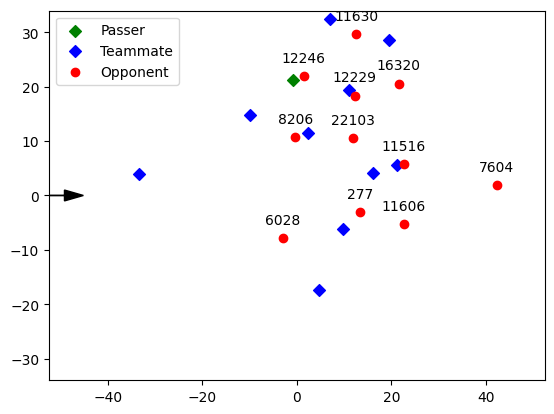

In [10]:
# frame_id = np.random.choice(passes_df['frame'].unique())
frame_id = 48981
plot_frame(passes_df, frame_id)

# Defender Position Score Visualization

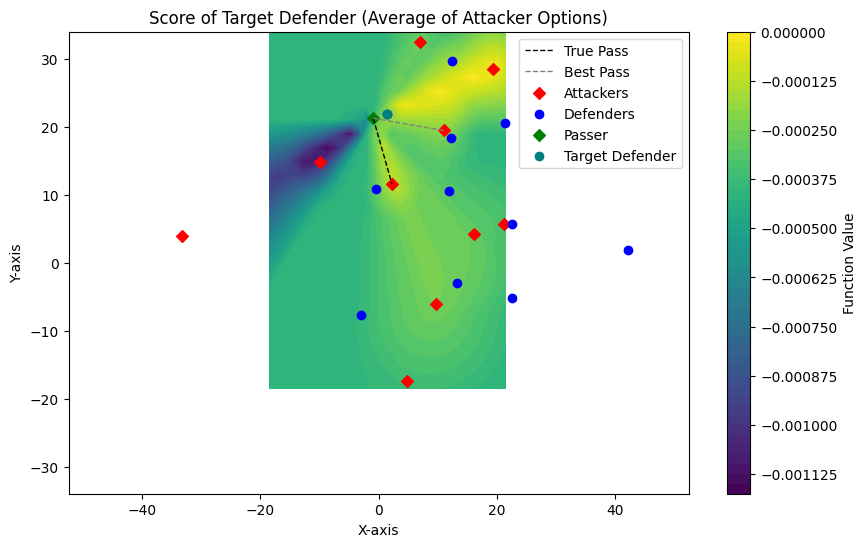

In [11]:
frame_id = 48981
defender_id = 12246

opt_func = create_opt_func(passes_df, frame_id, defender_id)
threat_agg = threat_aggregator('mean')

# Get target defender's true location
x_def, y_def = defender_true_location(passes_df, frame_id, defender_id)

# Get achieved score of the target defender
true_scores = opt_func(x_def, y_def)
true_score = threat_agg(true_scores)
max_threat_receiver_id = max(true_scores, key=true_scores.get)

# Create a meshgrid around the origin point
x = np.linspace(max(x_def - 20, -pitch_length/2), min(x_def + 20, pitch_length/2), 30)
y = np.linspace(max(x_def -20, -pitch_width/2), min(y_def + 20, pitch_length/2), 30)
X, Y = np.meshgrid(x, y)

# Evaluate the function on the grid
Z = np.zeros_like(X)
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        Z[i, j] = -threat_agg((opt_func(X[i,j],Y[i,j])))

# Plot the function
plt.figure(figsize=(10, 6))
plt.contourf(X, Y, Z, levels=50, cmap='viridis')
plt.colorbar(label='Function Value')

plot_players(passes_df, frame_id, defender_id, max_threat_receiver_id)

plt.legend()
plt.title('Score of Target Defender (Average of Attacker Options)')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.xlim([-pitch_length/2, pitch_length/2])
plt.ylim([-pitch_width/2, pitch_width/2])
plt.show()

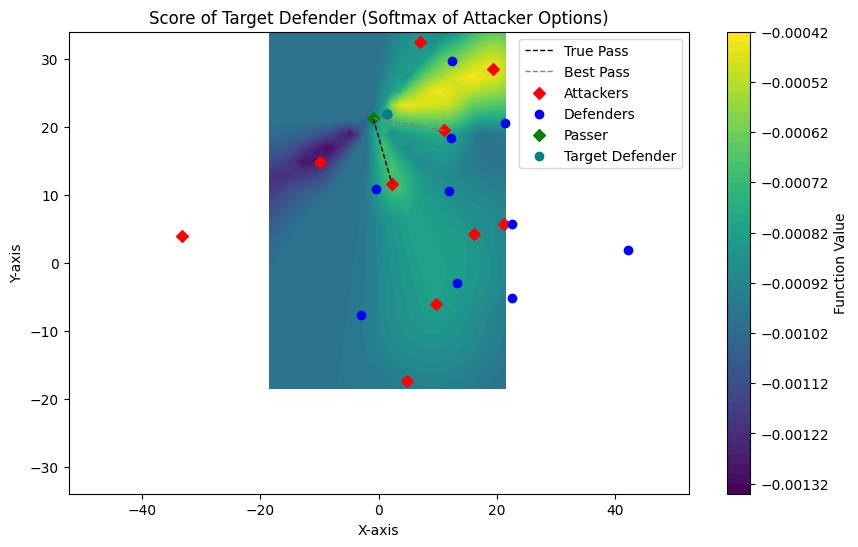

In [12]:
frame_id = 48981
defender_id = 12246

opt_func = create_opt_func(passes_df, frame_id, defender_id)
threat_agg = threat_aggregator('softmax', temp=0.01)

# Get target defender's true location
x_def, y_def = defender_true_location(passes_df, frame_id, defender_id)

# Get achieved score of the target defender
true_scores = opt_func(x_def, y_def)
true_score = threat_agg(true_scores)
max_threat_receiver_id = max(true_scores, key=true_scores.get)

# Create a meshgrid around the origin point
x = np.linspace(max(x_def - 20, -pitch_length/2), min(x_def + 20, pitch_length/2), 30)
y = np.linspace(max(x_def -20, -pitch_width/2), min(y_def + 20, pitch_length/2), 30)
X, Y = np.meshgrid(x, y)

# Evaluate the function on the grid
Z = np.zeros_like(X)
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        Z[i, j] = -threat_agg((opt_func(X[i,j],Y[i,j])))

# Plot the function
plt.figure(figsize=(10, 6))
plt.contourf(X, Y, Z, levels=50, cmap='viridis')
plt.colorbar(label='Function Value')

plot_players(passes_df, frame_id, defender_id, max_threat_receiver_id)

plt.legend()
plt.title('Score of Target Defender (Softmax of Attacker Options)')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.xlim([-pitch_length/2, pitch_length/2])
plt.ylim([-pitch_width/2, pitch_width/2])
plt.show()

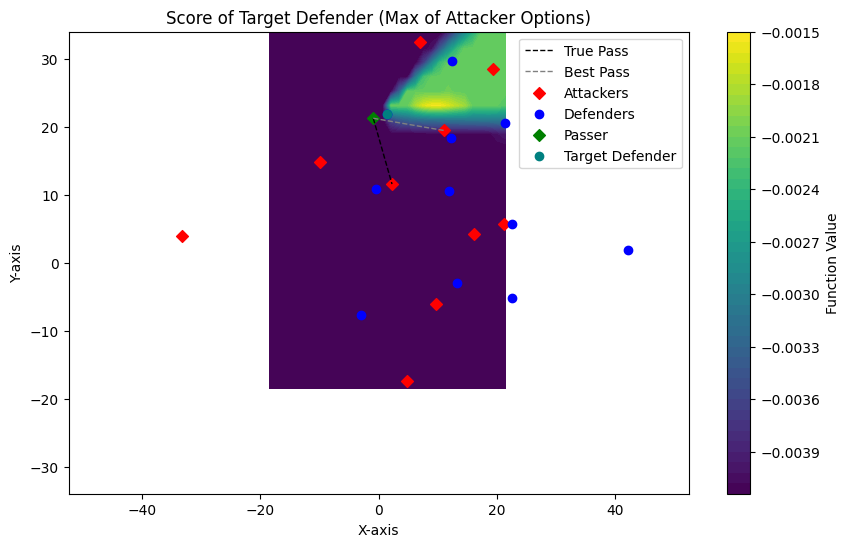

In [13]:
frame_id = 48981
defender_id = 12246

opt_func = create_opt_func(passes_df, frame_id, defender_id)
threat_agg = threat_aggregator('max')

# Get target defender's true location
x_def, y_def = defender_true_location(passes_df, frame_id, defender_id)

# Get achieved score of the target defender
true_scores = opt_func(x_def, y_def)
true_score = threat_agg(true_scores)
max_threat_receiver_id = max(true_scores, key=true_scores.get)

# Create a meshgrid around the origin point
x = np.linspace(max(x_def - 20, -pitch_length/2), min(x_def + 20, pitch_length/2), 30)
y = np.linspace(max(x_def -20, -pitch_width/2), min(y_def + 20, pitch_length/2), 30)
X, Y = np.meshgrid(x, y)

# Evaluate the function on the grid
Z = np.zeros_like(X)
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        Z[i, j] = -threat_agg((opt_func(X[i,j],Y[i,j])))

# Plot the function
plt.figure(figsize=(10, 6))
plt.contourf(X, Y, Z, levels=50, cmap='viridis')
plt.colorbar(label='Function Value')

plot_players(passes_df, frame_id, defender_id, max_threat_receiver_id)

plt.legend()
plt.title('Score of Target Defender (Max of Attacker Options)')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.xlim([-pitch_length/2, pitch_length/2])
plt.ylim([-pitch_width/2, pitch_width/2])
plt.show()

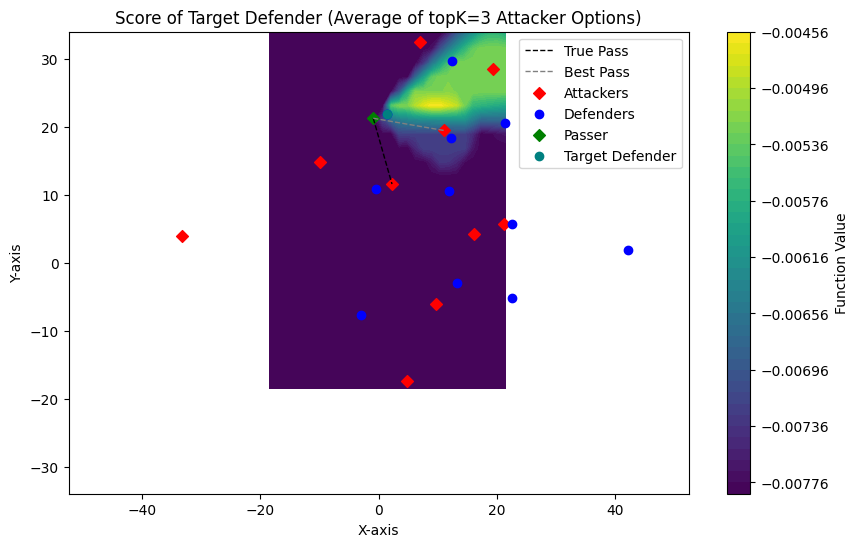

In [16]:
frame_id = 48981
defender_id = 12246

opt_func = create_opt_func(passes_df, frame_id, defender_id)
threat_agg = threat_aggregator('topK', k=3)

# Get target defender's true location
x_def, y_def = defender_true_location(passes_df, frame_id, defender_id)

# Get achieved score of the target defender
true_scores = opt_func(x_def, y_def)
true_score = threat_agg(true_scores)
max_threat_receiver_id = max(true_scores, key=true_scores.get)

# Create a meshgrid around the origin point
x = np.linspace(max(x_def - 20, -pitch_length/2), min(x_def + 20, pitch_length/2), 30)
y = np.linspace(max(x_def -20, -pitch_width/2), min(y_def + 20, pitch_length/2), 30)
X, Y = np.meshgrid(x, y)

# Evaluate the function on the grid
Z = np.zeros_like(X)
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        Z[i, j] = -threat_agg((opt_func(X[i,j],Y[i,j])))

# Plot the function
plt.figure(figsize=(10, 6))
plt.contourf(X, Y, Z, levels=50, cmap='viridis')
plt.colorbar(label='Function Value')

plot_players(passes_df, frame_id, defender_id, max_threat_receiver_id)

plt.legend()
plt.title('Score of Target Defender (Average of topK=3 Attacker Options)')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.xlim([-pitch_length/2, pitch_length/2])
plt.ylim([-pitch_width/2, pitch_width/2])
plt.show()

# Best Passing Option

/var/folders/53/t55qdy3d6n5fqv80nztwthtr0000gn/T/ipykernel_13443/1403425348.py:35: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('viridis', num_labels)


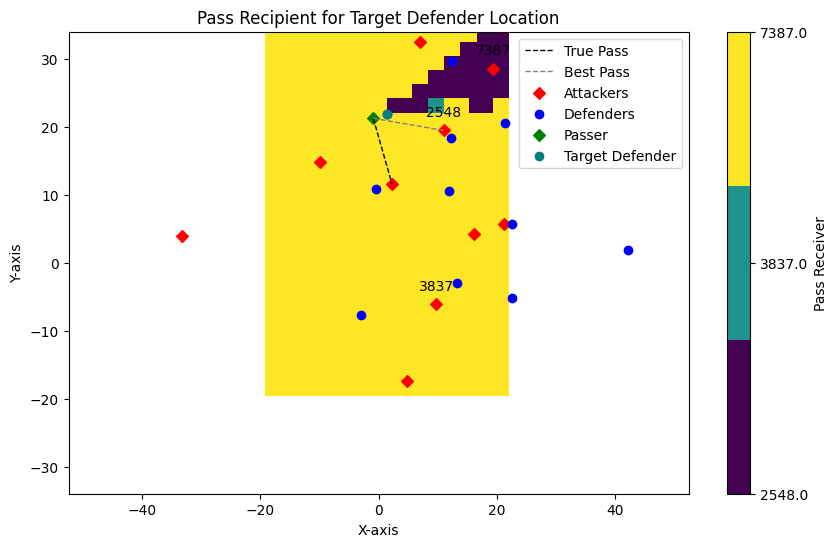

In [15]:
frame_id = 48981
defender_id = 12246

opt_func = create_opt_func(passes_df, frame_id, defender_id)
threat_agg = threat_aggregator('max')

# Get target defender's true location
x_def, y_def = defender_true_location(passes_df, frame_id, defender_id)

# Get achieved score of the target defender
true_scores = opt_func(x_def, y_def)
true_score = threat_agg(true_scores)
max_threat_receiver_id = max(true_scores, key=true_scores.get)

# Create a meshgrid around the origin point
x = np.linspace(max(x_def - 20, -pitch_length/2), min(x_def + 20, pitch_length/2), 30)
y = np.linspace(max(x_def -20, -pitch_width/2), min(y_def + 20, pitch_length/2), 30)
X, Y = np.meshgrid(x, y)

# Evaluate the function on the grid
Z = np.zeros_like(X)
P = np.zeros_like(X)
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        true_scores = opt_func(X[i,j],Y[i,j])
        Z[i, j] = -max(true_scores.values())
        P[i, j] = max(true_scores, key=true_scores.get)  

# Create pass receiver colormap
unique_labels = np.unique(P)
num_labels = len(unique_labels)
label_to_class = {label: idx for idx, label in enumerate(unique_labels)}
class_to_label = {idx: label for idx, label in enumerate(unique_labels)}
P_class = np.vectorize(label_to_class.get)(P)
cmap = plt.cm.get_cmap('viridis', num_labels)

plt.figure(figsize=(10, 6))
mesh = plt.pcolormesh(X, Y, P_class, cmap=cmap, shading='auto')
cbar = plt.colorbar(mesh, ticks=np.arange(num_labels))
cbar.ax.set_yticklabels([str(class_to_label[i]) for i in range(num_labels)])
cbar.set_label('Pass Receiver')

plot_players(passes_df, frame_id, defender_id, max_threat_receiver_id)

ax = plt.gca()
for label in unique_labels:
    x, y = passes_df[(passes_df['frame'] == frame_id) & (passes_df['tracking.object_id'] == label)][['tracking.x', 'tracking.y']].values[0]
    ax.annotate(int(label), (x, y), textcoords="offset points", xytext=(0,10), ha='center')

plt.legend()
plt.title('Pass Recipient for Target Defender Location')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.xlim([-pitch_length/2, pitch_length/2])
plt.ylim([-pitch_width/2, pitch_width/2])
plt.show()